# Photutils tutorial


## Morphological properties
Source: https://photutils.readthedocs.io/en/stable/morphology.html

## Elliptical Isophote Analysis
Source: https://photutils.readthedocs.io/en/stable/isophote.html

In [36]:
# import relevant packages
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import Gaussian2D
from astropy.stats import sigma_clipped_stats
from photutils.datasets import make_noise_image
from photutils.isophote import EllipseGeometry, Ellipse, build_ellipse_model
from photutils import EllipticalAperture, data_properties
from astropy.io import fits
from astropy.visualization import simple_norm

In [8]:
#data = g(x, y) + noise
hdu=fits.open('/Users/lasilla/data/2020-02-11/reduced/NGC2217/aNGC2217_B.fits')
data = hdu['PRIMARY'].data

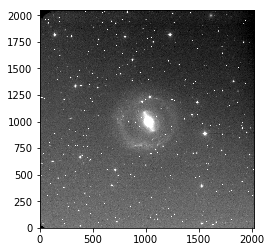

In [10]:
# how does it look?
plt.imshow(data, cmap='gray', origin='lower', vmin=-0.1, vmax=0.8)

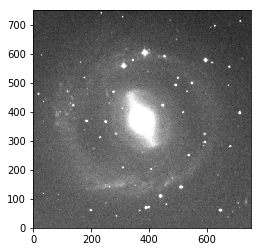

In [17]:
#cut
from astropy.nddata import Cutout2D
position = (1023, 1003)
size=(750,750)
cutout=Cutout2D (data,position,size)
plt.imshow(cutout.data,cmap='gray', origin='lower', vmin=-0.1, vmax=0.8)

We first need to estimate an initial guess of the ellipse geometry and pass it to the fitters.

In [18]:
# image statistics 
mean, median, std = sigma_clipped_stats(cutout.data, sigma=3.0)
# subract background
data_sub = cutout.data - median
# first guess
cat = data_properties(data_sub)
columns = ['id', 'xcentroid', 'ycentroid', 'semimajor_axis_sigma',
           'semiminor_axis_sigma', 'orientation']
tbl = cat.to_table(columns=columns)
# initialize an ellipse with the properties that we guessed
geometry = EllipseGeometry(x0=tbl['xcentroid'][0].value,
                           y0=tbl['ycentroid'][0].value,
                           pa=tbl['orientation'][0].value,
                           sma=tbl['semimajor_axis_sigma'][0].value,
                           eps=tbl['semiminor_axis_sigma'][0].value/tbl['semimajor_axis_sigma'][0].value
                           )

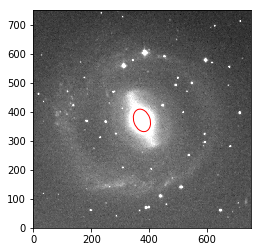

In [30]:
# how does it look?
geometry = EllipseGeometry (x0=375, y0=370, sma=40, eps=0.7,pa=110*np.pi/180)

plt.imshow(cutout.data, cmap='gray', origin='lower', vmin=-0.1, vmax=0.8)
geometry.sma
aper = EllipticalAperture(positions=(geometry.x0, geometry.y0), 
                          a=geometry.sma,
                          b=geometry.sma*(geometry.eps),
                          theta=geometry.pa)
aper.plot(color='r')

Now we want to initiliaze an instance of the Ellipse class with the data and our initial guess and fit the data:

In [31]:
ellipse = Ellipse(data_sub, geometry)
isolist = ellipse.fit_image()

In [32]:
# save the output as a table
tab = isolist.to_table()
tab

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad_rerr,ndata,flag,niter,stop_code
,,,,,deg,deg,,,,,
float64,float64,float64,float64,float64,float64,float64,object,int64,int64,int64,int64
0.0,33.3587341947296,0.0,0.0,0.0,0.0,0.0,None,1,0,0,0
0.5487684808459423,32.26126900208538,0.030018229530615125,0.1717098968626724,0.023776737554665004,87.9095105732,4.88301560695,0.3952381301788743,13,0,10,0
0.6036453289305366,32.14901721401558,0.03283398221860459,0.17236993539401146,0.023729902391560496,87.7842423805,4.6409435242,0.39438713569724365,13,0,10,0
0.6640098618235902,32.02610787331098,0.03590371992248461,0.17308630471445285,0.023285255763032753,87.6482192963,4.55789691446,0.3935801783358291,13,0,10,0
0.7304108480059492,31.891619976183332,0.039250837974016795,0.17387674910061393,0.02364906000637169,87.5073160518,4.53852763066,0.39285392894456433,13,0,10,0
0.8034519328065441,31.74452160010641,0.0428988702047573,0.1747310950233132,0.023478024617146973,87.3499511123,4.52076325819,0.3922198973188275,13,0,10,0
0.8837971260871986,31.583762370530426,0.046876851546969175,0.17566909982067233,0.023488767784249673,87.1814029428,4.47297918106,0.39173184099460756,13,0,10,0
0.9721768386959185,31.408233557532363,0.0512110796477565,0.17674352492966794,0.020580614527516812,86.980812628,3.90723052388,0.31964126469282117,13,0,10,0


Text(0,0.5,'Ellipticity')

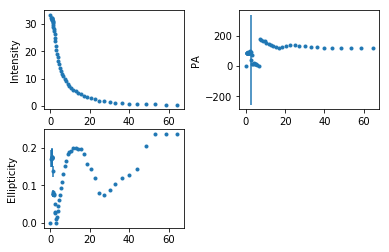

In [33]:
# have a look at some of the fitted parameters:
fig = plt.figure()
ax1 = fig.add_subplot(221)
fig.subplots_adjust(wspace=0.4)
ax1.errorbar(tab['sma'], tab['intens'],
             yerr=tab['intens_err'],
             fmt='.')
ax1.set_ylabel('Intensity')
ax2 = fig.add_subplot(222, sharex=ax1)
ax2.errorbar(tab['sma'], tab['pa'].value,
             yerr=tab['pa_err'].value,
             fmt='.')
ax2.set_ylabel('PA')
ax3 = fig.add_subplot(223, sharex=ax1)
ax3.errorbar(tab['sma'], tab['ellipticity'],
             yerr=tab['ellipticity_err'],
             fmt='.')
ax3.set_ylabel('Ellipticity')
# ax4 = fig.add_subplot(224, sharex=ax1)
# ax4.errorbar(tab['sma'], tab['x0'],
#              yerr=tab['x0_err'],
#              fmt='.')
# ax4.set_ylabel('x0')

We can also build a model image from the fit that we just calculated and deterime the residuals of the fit:

In [34]:
model_image = build_ellipse_model(cutout.data.shape, isolist)
residual = cutout.data - model_image

Text(0.5,1,'Residual')

<Figure size 432x288 with 0 Axes>

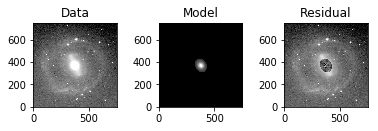

In [41]:
norm_model = simple_norm(model_image,stretch='asinh',percent=99.9)
norm_data = simple_norm(cutout.data,stretch='asinh',percent=98)
fig = plt.figure()
fig = plt.figure()
fig.subplots_adjust(wspace=0.5)
ax1 = fig.add_subplot(131)
ax1.imshow(cutout.data, cmap='gray', origin='lower',norm=norm_data )
ax1.set_title('Data')
ax2 = fig.add_subplot(132)
ax2.imshow(model_image, cmap='gray', origin='lower', norm=norm_model)
ax2.set_title('Model')
ax3 = fig.add_subplot(133)
ax3.imshow(residual, cmap='gray', origin='lower', norm=norm_data)
ax3.set_title('Residual')